# Sentiment Analysis on Twitter Dataset (Sentiment140)

#### EsterHlav
#### Oct 6, 2019

## Download Twitter dataset

Run the setup shell file to download and organize the dataset.

In [1]:
!sh setup.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   270  100   270    0     0   1875      0 --:--:-- --:--:-- --:--:--  1862
100 77.5M  100 77.5M    0     0  44.5M      0  0:00:01  0:00:01 --:--:-- 71.6M
Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   326    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   363    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1449M  100 1449M    0     0  58.5M      0  0:00:24  0:00:24 --:--:-- 62.0M
Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.t

## Data Preprocessing

In [0]:
%load_ext autoreload
%autoreload 2
from data_preprocessing import *

In [0]:
# load GloVe embeddings
word2vectors, word2id = load_GloVe_twitter_emb()
# load the twitter dataset and splits in train/val/test
train, val, test = load_twitter_datasets(n_train=25000, n_val=8000)

Example of preprocessing with first 25 tweets

In [0]:
tweets = train.tweet.apply(glove_preprocess).apply(normalize_text).values

In [4]:
# original tweets
train.tweet.values[:25]

array(['Wow, today was interesting! ',
       '@mikeywhite bring me back some redbull. ',
       "Sitting up listening to music till 4am cause you're upset isn't wise. Boo to only 6 hours sleep ",
       "I'm sure. I give up.... ",
       "@jmarie7481 No! You can't blame me. I saw the sale yesterday but was too nice to tell you. Okay actually I was going to tell you tonight! ",
       "I can't find my chapstick! ", 'Last few hrs with the team. Sad ',
       'sagt thanks for the pizza Francis! And good luck in your new job!  http://plurk.com/p/tqfml',
       '@avenue_a The rocky kind! With little rockpools &amp; octopi &amp; shells &amp; stuff. Now I want to be at the beach. Its the perfect overcast day. ',
       '@williamvisk Your musical compatibility with williamvisk is VERY HIGH ',
       'was searching for Twitter Mobile Application for My Nokia 5320 phone, but twitter has not released it yet.. ',
       'late nights are the best. especially with drew and jesse. ',
       '@johnma

In [5]:
# after preprocessing
tweets[:25]

array(['wow today was interesting', '<user> bring me back some redbull',
       'sitting up listening to music till <number> am cause you are upset is not wise boo to only <number> hours sleep',
       'i am sure i give up',
       '<user> no you can not blame me i saw the sale yesterday but was too nice to tell you okay actually i was going to tell you tonight',
       'i can not find my chapstick', 'last few hrs with the team sad',
       'sagt thanks for the pizza francis and good luck in your new job <elong> <url>',
       '<user> the rocky kind with little rockpools amp octopi amp shells amp stuff now i want to be at the beach its the perfect overcast day',
       '<user> your musical compatibility with williamvisk is very <allcaps> high <allcaps>',
       'was searching for twitter mobile application for my nokia <number> phone but twitter has not released it yet',
       'late nights are the best especially with drew and jesse',
       '<user> i never understand your tweets im t

Create the tensors to feed to a MLP

In [0]:
Xtrain, Ytrain = processAllTweets2vec(train, word2vectors)
Xval, Yval = processAllTweets2vec(val, word2vectors)
Xtest, Ytest = processAllTweets2vec(test, word2vectors)

In [7]:
Xtrain.shape, Ytrain.shape

((25000, 200), (25000, 1))

## MLP

In [0]:
from models import *

Create PyTorch DataLoader

In [0]:
# create Tensor datasets
train_data = TensorDataset(convertToTorchFloat(Xtrain), convertToTorchFloat(Ytrain))
val_data = TensorDataset(convertToTorchFloat(Xval), convertToTorchFloat(Yval))
test_data = TensorDataset(convertToTorchFloat(Xtest), convertToTorchFloat(Ytest))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

Create MLP model

In [11]:
mlp = NetMLP(input_size=200, layer_sizes=[128, 32], activation=nn.Tanh(), 
          epochs=50, learning_rate=0.0002, l2reg=5e-4, dropout=0)

mlp = mlp.cuda() if torch.cuda.is_available() else mlp

print ("Number of parameters: {}".format(sum([np.prod(p.size()) for p in mlp.parameters()])))

Number of parameters: 29889


Train MLP model

In [12]:
history = mlp.fit(train_loader, val_loader)
test_performance = mlp.evaluate_loader(test_loader)
print ("\nTest  performance: loss={:.3f}, accuracy={:.3f}, precision={:.3f}, recall={:.3f}, f1={:.3f}".format(*[ test_performance[m] for m in ['loss', 'accuracy', 'precision', 'recall', 'f1']]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/50
Train performance: loss=0.636, accuracy=0.651, precision=0.685, recall=0.515, f1=0.560
Val   performance: loss=0.571, accuracy=0.707, precision=0.730, recall=0.656, f1=0.690
Epoch 6/50
Train performance: loss=0.511, accuracy=0.748, precision=0.748, recall=0.745, f1=0.743
Val   performance: loss=0.511, accuracy=0.748, precision=0.746, recall=0.752, f1=0.748
Epoch 11/50
Train performance: loss=0.508, accuracy=0.754, precision=0.754, recall=0.748, f1=0.748
Val   performance: loss=0.510, accuracy=0.748, precision=0.731, recall=0.784, f1=0.756
Epoch 16/50
Train performance: loss=0.506, accuracy=0.752, precision=0.751, recall=0.748, f1=0.747
Val   performance: loss=0.510, accuracy=0.748, precision=0.761, recall=0.721, f1=0.739
Epoch 21/50
Train performance: loss=0.506, accuracy=0.753, precision=0.753, recall=0.749, f1=0.748
Val   performance: loss=0.508, accuracy=0.752, precision=0.754, recall=0.748, f1=0.750
Epoch 26/50
Train performance: loss=0.505, accuracy=0.754, precision=0.7

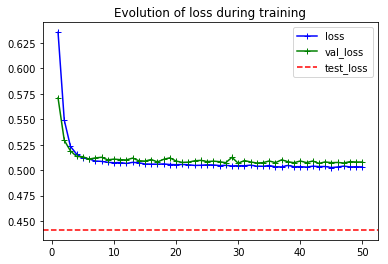

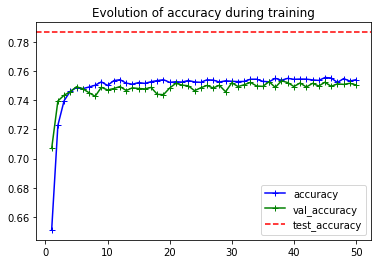

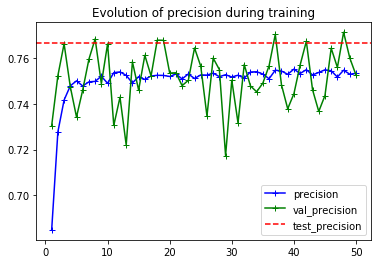

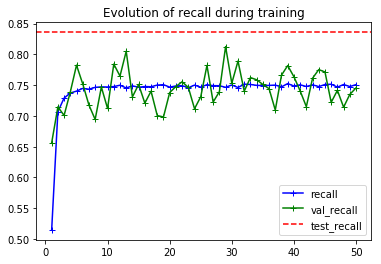

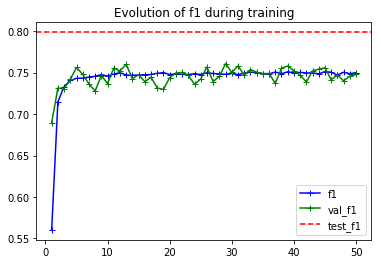

In [13]:
plot_perf(history, test_performance)

In [32]:
len(test_loader.dataset)

358

## CNN

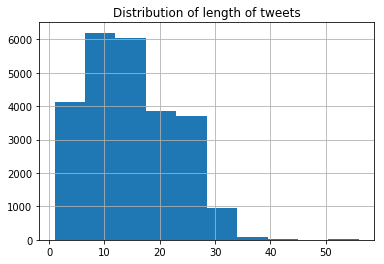

In [14]:
# look into distribution of length of tweets to determine optimal padding
import matplotlib.pyplot as plt
train.tweet.apply(glove_preprocess).apply(normalize_text).apply(lambda x: len(x.split(' '))).hist()
plt.title('Distribution of length of tweets')
plt.show()

Create embedding matrix

In [15]:
vocab = extractVocabulary(train)
restrictedWord2id, embMatrix = vocabEmbeddings(vocab, word2vectors)

100%|██████████| 25000/25000 [00:09<00:00, 2683.20it/s]


In [16]:
embMatrix.shape

(13175, 200)

Process all tweets to tokens in matrix format to feed to CNN model

In [0]:
Xtrain, Ytrain = processAllTweets2tok(train, restrictedWord2id)
Xval, Yval = processAllTweets2tok(val, restrictedWord2id)
Xtest, Ytest = processAllTweets2tok(test, restrictedWord2id)

In [18]:
Xtrain.shape, Ytrain.shape

((25000, 40), (25000, 1))

Create PyTorch DataLoader

In [0]:
# create Tensor datasets
train_data = TensorDataset(convertToTorchInt(Xtrain), convertToTorchFloat(Ytrain))
val_data = TensorDataset(convertToTorchInt(Xval), convertToTorchFloat(Yval))
test_data = TensorDataset(convertToTorchInt(Xtest), convertToTorchFloat(Ytest))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

Create CNN model

In [31]:
cnn = NetCNN(vocab_size=embMatrix.shape[0], embedding_matrix=embMatrix, 
             filter_sizes=[1, 2, 3, 5, 10], num_filters=8, embed_size=embMatrix.shape[1], 
             finetune_emb=False, epochs=150, learning_rate=2e-5, l2reg=3e-3, dropout=0.1)

cnn = cnn.cuda() if torch.cuda.is_available() else cnn
print (cnn)
print (sum([np.prod(p.size()) for p in cnn.parameters()])-np.prod(embMatrix.shape))

NetCNN(
  (embedding): Embedding(13217, 200)
  (convs1): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 8, kernel_size=(2, 200), stride=(1, 1))
    (2): Conv2d(1, 8, kernel_size=(3, 200), stride=(1, 1))
    (3): Conv2d(1, 8, kernel_size=(5, 200), stride=(1, 1))
    (4): Conv2d(1, 8, kernel_size=(10, 200), stride=(1, 1))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (finalActivation): Sigmoid()
  (criterion): BCELoss()
)
33681


Train CNN model

In [32]:
history = cnn.fit(train_loader, val_loader)
test_performance = cnn.evaluate_loader(test_loader)
print ("Test performance: loss={:.3f}, accuracy={:.3f}, precision={:.3f}, recall={:.3f}, f1={:.3f}".format(*[ test_performance[m] for m in ['loss', 'accuracy', 'precision', 'recall', 'f1']]))

Epoch 1/150
Train performance: loss=0.695, accuracy=0.523, precision=0.514, recall=0.911, f1=0.654
Val   performance: loss=0.684, accuracy=0.567, precision=0.549, recall=0.734, f1=0.627
Epoch 6/150
Train performance: loss=0.636, accuracy=0.673, precision=0.678, recall=0.656, f1=0.665
Val   performance: loss=0.632, accuracy=0.676, precision=0.682, recall=0.662, f1=0.670
Epoch 11/150
Train performance: loss=0.596, accuracy=0.701, precision=0.705, recall=0.688, f1=0.695
Val   performance: loss=0.594, accuracy=0.704, precision=0.704, recall=0.699, f1=0.700
Epoch 16/150
Train performance: loss=0.567, accuracy=0.720, precision=0.725, recall=0.704, f1=0.713
Val   performance: loss=0.567, accuracy=0.726, precision=0.729, recall=0.717, f1=0.721
Epoch 21/150
Train performance: loss=0.545, accuracy=0.736, precision=0.740, recall=0.724, f1=0.731
Val   performance: loss=0.548, accuracy=0.731, precision=0.728, recall=0.736, f1=0.730
Epoch 26/150
Train performance: loss=0.528, accuracy=0.748, precisi

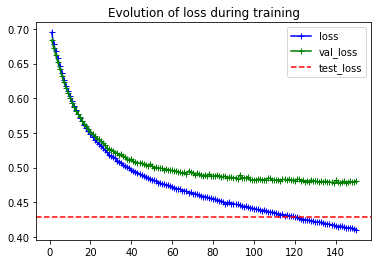

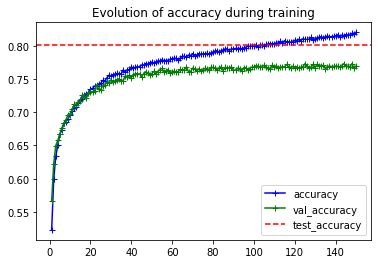

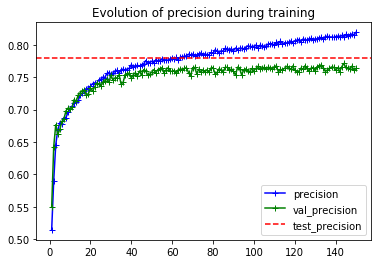

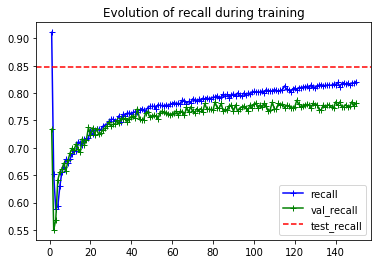

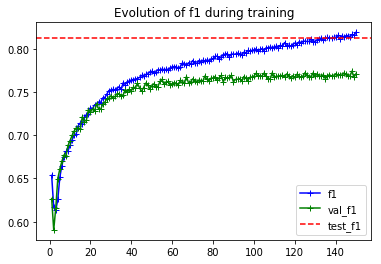

In [33]:
plot_perf(history, test_performance)

## CNN with embedding finetuning

In [27]:
cnn_embfinetune = NetCNN(vocab_size=embMatrix.shape[0], embedding_matrix=embMatrix, 
             filter_sizes=[1,2,3,5,10], num_filters=8, embed_size=embMatrix.shape[1], 
             finetune_emb=True, epochs=200, learning_rate=0.00002, l2reg=2e-3, dropout=0.25)

cnn_embfinetune = cnn_embfinetune.cuda() if torch.cuda.is_available() else cnn
print (cnn_embfinetune)
print (sum([np.prod(p.size()) for p in cnn_embfinetune.parameters()]))

NetCNN(
  (embedding): Embedding(13175, 200)
  (convs1): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 8, kernel_size=(2, 200), stride=(1, 1))
    (2): Conv2d(1, 8, kernel_size=(3, 200), stride=(1, 1))
    (3): Conv2d(1, 8, kernel_size=(5, 200), stride=(1, 1))
    (4): Conv2d(1, 8, kernel_size=(10, 200), stride=(1, 1))
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (finalActivation): Sigmoid()
  (criterion): BCELoss()
)
2668681


In [28]:
history = cnn_embfinetune.fit(train_loader, val_loader)
test_performance = cnn_embfinetune.evaluate_loader(test_loader)
print ("Test performance: loss={:.3f}, accuracy={:.3f}, precision={:.3f}, recall={:.3f}, f1={:.3f}".format(*[ test_performance[m] for m in ['loss', 'accuracy', 'precision', 'recall', 'f1']]))

Epoch 1/200
Train performance: loss=0.691, accuracy=0.527, precision=0.519, recall=0.673, f1=0.582
Val   performance: loss=0.686, accuracy=0.551, precision=0.552, recall=0.543, f1=0.546
Epoch 6/200
Train performance: loss=0.647, accuracy=0.654, precision=0.658, recall=0.630, f1=0.642
Val   performance: loss=0.641, accuracy=0.666, precision=0.676, recall=0.637, f1=0.654
Epoch 11/200
Train performance: loss=0.610, accuracy=0.690, precision=0.696, recall=0.666, f1=0.679
Val   performance: loss=0.608, accuracy=0.687, precision=0.698, recall=0.659, f1=0.676
Epoch 16/200
Train performance: loss=0.580, accuracy=0.716, precision=0.722, recall=0.693, f1=0.706
Val   performance: loss=0.581, accuracy=0.707, precision=0.712, recall=0.700, f1=0.704
Epoch 21/200
Train performance: loss=0.560, accuracy=0.728, precision=0.733, recall=0.709, f1=0.719
Val   performance: loss=0.562, accuracy=0.725, precision=0.730, recall=0.716, f1=0.721
Epoch 26/200
Train performance: loss=0.542, accuracy=0.741, precisi

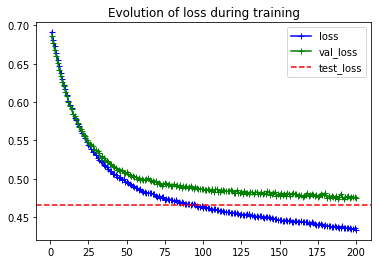

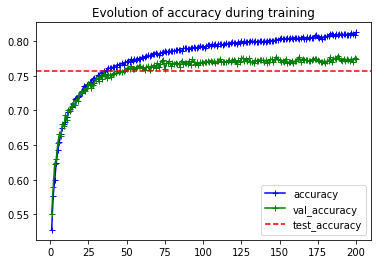

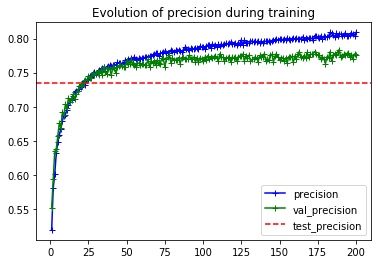

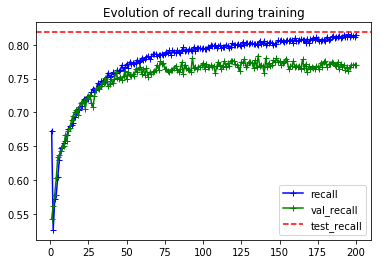

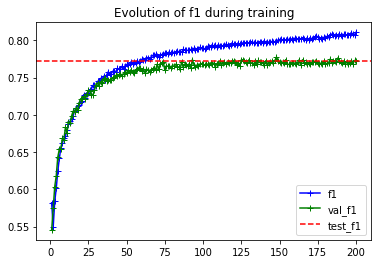

In [29]:
plot_perf(history, test_performance)

### Results

| Val performance (8K samples)              |  Loss | Accuracy | Precision | Recall | F1-score |
|-------------------------------|:-----:|:--------:|:---------:|--------|----------|
| MLP (~30K params)                  | 0. 508|   0.750  |   0.764   |  0.722 |   0.741  |
| CNN (~33K params)             | 0.479 |   0.769  |   0.765   |  **0.775** |   0.768  |
| CNN with fine-tune embedding (~2.6M params)  | **0.475** |   **0.772**  |   **0.773**   |  0.767 |   **0.769**  |

| Test performance (358 samples)             |  Loss | Accuracy | Precision | Recall | F1-score |
|-------------------------------|:-----:|:--------:|:---------:|--------|----------|
| MLP (~30K params)                  | 0.441 |   0.787  |   0.767   |  0.836 |   0.799  |
| CNN (~33K params)             | **0.429** |   **0.801**  |   **0.780**   |  **0.847** |   **0.812**  |
| CNN with fine-tune embedding (~2.6M params)  | 0.465 |   0.757  |   0.735   |  0.818 |   0.772  |